# DPC Torque Control — Policy Evaluation Example

This notebook demonstrates comprehensive evaluation of trained DPC policy on PMSM motor.
It provides detailed analysis including transient response, steady-state performance, and comparison
with optimal control solutions (OCP).

## Overview
- **Goal:** Evaluate trained neural network policy performance across operating range
- **Scope:** Single-point evaluation, steady-state grid analysis, and transient comparison with OCP
- **Outputs:** Performance metrics, visualization plots, and trajectory comparisons

## Notebook Sections

1. **Setup & Dependencies** - Import libraries and configure environment
2. **Motor Definition** - Initialize PMSM with physical parameters
3. **Policy Loading** - Load trained neural network from checkpoint
4. **Single-Point Evaluation** - Evaluate at specific speed/torque, compare with analytical optimum
5. **Steady-State Analysis** - Grid evaluation across speed/torque range, compute error statistics
6. **Transient Analysis** - Fine-grained grid for detailed trajectory comparison with open-loop OCP
7. **OCP Benchmark** - Compare DPC against optimal control solutions (solve or load)
8. **Results Visualization** - Plot DPC vs OCP trajectories and settling times

## 1. Setup & Dependencies

### Import External Libraries and Configure Environment

In [1]:
"""
Import external dependencies for numerical computation, JAX framework, and visualization.

Libraries used:
- JAX/Equinox: Automatic differentiation and neural network primitives
- NumPy: Numerical operations and array handling
- Optax: Gradient-based optimization algorithms
- Matplotlib: Data visualization and figure creation
- CasADi: Symbolic computation (for OCP solver)
"""

# Core scientific computing
import sys
from pathlib import Path
import numpy as np

# JAX ecosystem
import jax
import jax.nn as jnn
import jax.numpy as jnp
import equinox as eqx
import optax

# Visualization and data analysis
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, MaxNLocator

# Utilities
from functools import partial
from IPython.display import display, clear_output
import pandas as pd

# Symbolic computation (for OCP solver)
import casadi as ca

In [2]:
"""
Configure project root and add to Python path for local module imports.

This allows importing from policy/, utils/, and visualization/ directories.
"""

# Add project root to Python path for local imports
PROJECT_ROOT = Path().resolve().parents[0]
sys.path.insert(0, str(PROJECT_ROOT))

In [3]:
"""
Import project-specific modules for motor simulation, policy evaluation, and visualization.

Components:
- Motor Environment: PMSM physical simulator
- Policy Architecture: Neural network models
- Data Generation: Reference generation and feature extraction
- Loss Functions: Evaluation metrics
- Evaluation Tools: Trajectory analysis and comparison
- Visualization: Plot generation and analysis
"""

# Motor environment and simulation
from exciting_environments.pmsm.pmsm_env import PMSM

# Policy architecture and training
from policy.policy_training import DPCTrainer
from policy.networks import MLP

# Data generation and processing
from policy.data_generation import reset, generate_feasible, node_dat_gen_sin, featurize

# Diagnostics and evaluation
from policy.policy_training_diagnostics import plot_training_losses, check_speed_torque_distribution
from policy.evaluation import (
    steps_eval_manual,
    compute_steady_state_error,
    generate_mask,
    extract_fund_voltage_from_dpc
)
from policy.eval_visualization import (
    boxplot_error_by_bins,
    format_time_axis_ocp_comparison,
    calculate_settling_for_grid
)

# Utilities
from utils.generate_filenames import generate_filename
from utils.AnalyticalRG import check_analy_opt
from utils.OCP import generate_OCP_traj

# Visualization
from visualization.style import set_plot_style

In [4]:
"""
Configure JAX and matplotlib for this notebook session.

JAX Setup:
- Detect available GPU devices
- Set primary computation device (GPU if available, otherwise CPU)

Matplotlib Setup:
- Apply custom plot styling for consistent visualization
"""

# Configure JAX: use first available device (GPU preferred)
gpus = jax.devices()
jax.config.update("jax_default_device", gpus[0])

# Apply custom plot styling
set_plot_style()

## 2. Motor Definition

### Initialize PMSM with Physical Parameters

In [5]:
"""
Create PMSM (Permanent Magnet Synchronous Motor) environment instance.

Motor: BRUSA (electric vehicle traction motor)
Physical Parameters:
- Pole pairs (p): 3
- Stator resistance (r_s): 15 mΩ
- D-axis inductance (l_d): 0.37 mH
- Q-axis inductance (l_q): 1.2 mH
- Permanent magnet flux (psi_p): 65.6 mH
- Deadtime: 0 µs (ideal inverter)

Configuration:
- Batch size: 1 (single trajectory simulation)
- Saturation: Disabled (linear motor model)
- LUT: Look-up table motor characterization
"""

motor_env = PMSM(
    LUT_motor_name="BRUSA",
    saturated=False,
    batch_size=1,
    control_state=[],
    static_params={
        "p": 3,                    # Pole pairs
        "r_s": 15e-3,              # Stator resistance (Ω)
        "l_d": 0.37e-3,            # D-axis inductance (H)
        "l_q": 1.2e-3,             # Q-axis inductance (H)
        "psi_p": 65.6e-3,          # Permanent magnet flux (Wb)
        "deadtime": 0,             # Inverter deadtime (s)
    }
)

## 3. Policy Loading

#### Load Pre-Trained Policy Network

In [6]:
"""
Load trained DPC policy network from saved checkpoint.

Policy Architecture:
- Input: 8 features 
- Hidden layers: 3 × 128 units
- Output: 2 actions (d-axis and q-axis voltage commands)

Training Configuration (training parameters stored in checkpoint):
- Training steps: 500,000 iterations
- Horizon length: 60 timesteps
- Efficiency loss weight (ieff): 0.008
- Current limit weight (iL): 0.4
- Speed efficiency loss weight: 0.001
- Training stage: Final (converged)
"""

# Define network architecture (must match training configuration)
layer_size = 128
num_layers = 3
input_dim = 8                      # Motor state observation dimension
output_dim = 2                     # Action dimension (u_d, u_q)

# Build policy architecture
policy_archit = [input_dim] + [layer_size for _ in range(num_layers)] + [output_dim]

# Initialize policy with random weights (will be overwritten by checkpoint)
jax_key = jax.random.PRNGKey(6)
p2 = MLP(policy_archit, key=jax_key)

# Define checkpoint loading parameters
model_params = {
    "layer_sz": layer_size,
    "num_layers": num_layers,
    "steps": 500000,               # Total training iterations
    "h": 60,                       # Prediction horizon
    "ieff": 0.008,                 # Efficiency loss weight
    "iL": 0.4,                     # Current limit constraint weight
    "iLOffset": 1.02,              # Current offset parameter
    "lw_Speed_ieff": 0.001,        # Speed-dependent efficiency weight
    "stage": "final"               # Training stage (convergence indicator)
}

# Load trained weights from checkpoint
p2 = eqx.tree_deserialise_leaves(
    generate_filename(
        project_root=PROJECT_ROOT,
        prefix="policy/models/policy_hex",
        params=model_params
    ),
    p2
)

## 4. Single-Point Evaluation

### Evaluate Policy at Specific Speed and Torque Reference

This section performs detailed evaluation at a single operating point with analytical reference comparison.

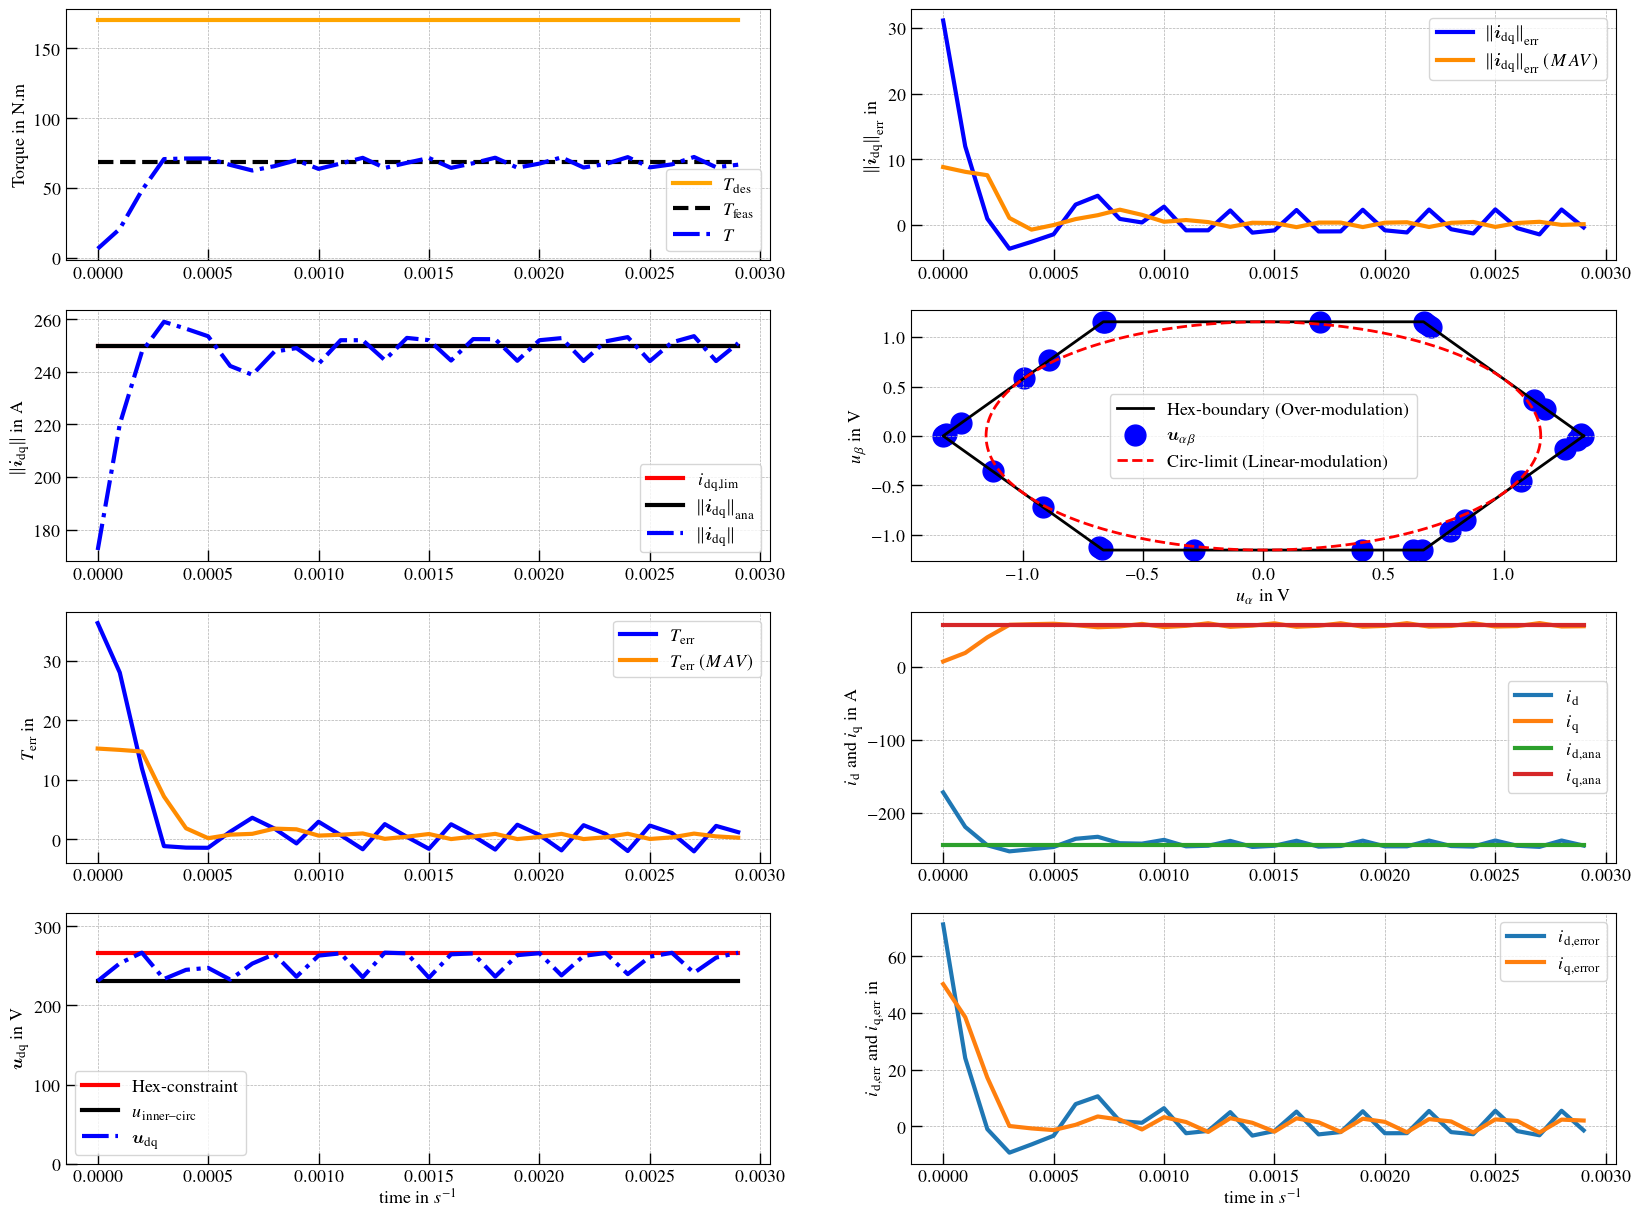

In [9]:
"""
Evaluate learned policy at single operating point with manual parameter selection.

Simulation Configuration:
- Torque reference: 90 N·m
- Mechanical speed: 3000 RPM 
- Step length: 30 simulation timesteps
- Plot trajectories: Display results during execution

Returns:
- obs: Motor observations from simulation 
- acts: Control actions from policy (u_d, u_q voltages)
- obs_des: Desired observations from reference generation
- obs_ref_ana: Analytical reference observations
- id_iq_ana: Reference d-q axis currents
- id_iq_sim: Simulated d-q axis currents
- trq_ach: Achieved torque trajectory
- trq_des: Desired torque trajectory
- trq_sim: Simulated torque trajectory
"""

# ========== Evaluation Settings ==========
trq = [170]                         # Reference torque (N·m)
sp = 11000                          # Operating mechanical speed (RPM)
step_len = 30                      # Rollout length (timesteps)
plot_trajectories = True           # Display plots during execution

# ========== Execute Evaluation ==========
obs, _, acts, obs_des, obs_ref_ana, acts_alb = steps_eval_manual(
    motor_env,
    reset,
    generate_feasible,
    p2,
    featurize,
    jax.random.PRNGKey(2),
    jnp.array(trq) / motor_env.env_properties.physical_constraints.torque,
    plot=plot_trajectories,
    omega_el_coeff=sp * (3 * 2 * jnp.pi) / (60 * motor_env.env_properties.physical_constraints.omega_el),
    step_lens=[step_len, step_len]
)

# ========== Extract Physical States ==========
# Convert observations back to physical state space
ref_state = motor_env.vmap_generate_state_from_observation(obs_ref_ana, motor_env.env_properties).physical_state

sim_state = motor_env.vmap_generate_state_from_observation(obs, motor_env.env_properties).physical_state

des_state = motor_env.vmap_generate_state_from_observation(obs_des, motor_env.env_properties).physical_state

# ========== Extract Signals ==========
# Extract d-q current components (analytical and simulated)
id_iq_ana = jnp.concatenate(
    (ref_state.i_d.reshape(-1, 1), ref_state.i_q.reshape(-1, 1)), axis=1
)
id_iq_sim = jnp.concatenate(
    (sim_state.i_d.reshape(-1, 1), sim_state.i_q.reshape(-1, 1)), axis=1
)

# Extract torque signals
trq_ach = ref_state.torque
trq_des = des_state.torque
trq_sim = sim_state.torque

Plot d-q current trajectory and compare with theoretical optimal solution from analytical reference generation.

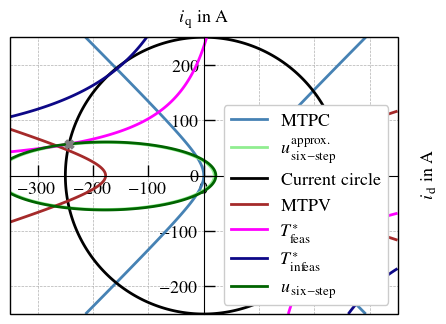

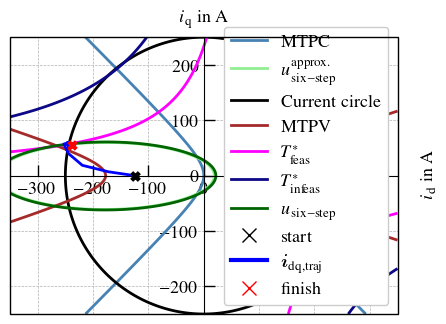

In [10]:
"""
Compare current trajectory against analytical optimum using constrained optimization.

This generates visualization of d-q current plane showing:
- Simulated trajectory (DPC policy output)
- Analytical optimum (Lagrange multiplier solution)
- Operating constraints (current limit, voltage hexagon, etc.)
"""

check_analy_opt(motor_env, trq_ach, trq_des, sim_state, id_iq_ana, id_iq_sim, step_len)

## 5. Steady-State Analysis

### Evaluate Policy Performance over Speed/Torque Grid (Large Scale)

#### Simulate Policy Over Fine Speed/Torque Grid

Evaluate performance across full operating range. This generates high-resolution steady-state error data.

**Grid Configuration:**
- Speeds: 300 points (covers 0 to maximum electrical speed)
- Torques: 60 points (covers 0 to maximum torque)
- Step length: 100 timesteps per trajectory (extended for steady-state settling)

In [9]:
"""
Grid-based policy evaluation over speed and torque operating points.

This performs systematic evaluation at 300 × 60 = 18,000 operating points.

Grid Configuration:
- Speeds: 300 linearly-spaced points from 0 to max electrical speed
- Torques: 60 linearly-spaced points from 0 to max torque (shuffled for sampling variety)
- Step length: 100 timesteps per trajectory

For each speed point, all torques are evaluated with fixed speed.
Results accumulated into arrays for statistical analysis.

Note: This is computationally intensive.
Consider reducing n_speeds/n_trqs for faster testing.
"""

# ========== Grid Configuration ==========
n_speeds = 300                     # Number of speed evaluation points
n_trqs = 60                        # Number of torque evaluation points
step_len = 100                     # Extended rollout for steady-state settling

# ========== Generate Grid Points ==========
speed = jnp.linspace(1e-4, 1, n_speeds)     # Normalized electrical speed [0, 1]
trq = jnp.linspace(1e-4, 1, n_trqs)         # Normalized torque [0, 1]
trq = jax.random.permutation(jax.random.PRNGKey(0), trq)  # Shuffle for variety

# ========== Accumulation Lists ==========
obs_list = []
obs_des_list = []
obs_ref_list = []
acts_list = []

# ========== Nested Loop: Evaluate All Combinations ==========
for i in speed:
    """Inner loop over all torque points at fixed speed"""
    obs, _, acts, obs_des, obs_ref_ana, _ = steps_eval_manual(
        motor_env,
        reset,
        generate_feasible,
        p2,
        featurize,
        jax.random.PRNGKey(2),
        trq,                       # All torques at this speed
        plot=False,
        omega_el_coeff=i,          # Fixed speed for this iteration
        step_lens=[step_len, step_len]
    )

    # Extract analytical and simulated states (for internal consistency check)
    ref_state = motor_env.vmap_generate_state_from_observation(
        obs_ref_ana, motor_env.env_properties
    ).physical_state
    sim_state = motor_env.vmap_generate_state_from_observation(
        obs, motor_env.env_properties
    ).physical_state
    des_state = motor_env.vmap_generate_state_from_observation(
        obs_des, motor_env.env_properties
    ).physical_state

    # Extract currents for validation
    id_iq_ana = jnp.concatenate(
        (ref_state.i_d.reshape(-1, 1), ref_state.i_q.reshape(-1, 1)), axis=1
    )
    id_iq_sim = jnp.concatenate(
        (sim_state.i_d.reshape(-1, 1), sim_state.i_q.reshape(-1, 1)), axis=1
    )

    # Accumulate results
    acts_list.append(acts)
    obs_list.append(obs)
    obs_ref_list.append(obs_ref_ana)

# ========== Stack Results into Arrays ==========
# Shape: (n_speeds, n_trqs*step_len, num_observations)
sim_data = jnp.stack(obs_list)
ref_data = jnp.stack(obs_ref_list)
acts_data = jnp.stack(acts_list)

#### Configure Feature Selection and Data Preprocessing

Define which features to analyze and prepare data arrays for visualization.

In [10]:
"""
Configure feature selection and preprocess grid data for analysis.

Features Selected:
- idq_mag: Current magnitude ||i_dq|| (index 2)
- Torque: Motor torque (index 3)

Preprocessing:
1. Sort torque indices for monotonic x-axis in plots
2. Scale normalized values to physical units
3. Reshape arrays for grid visualization
4. Generate feasibility mask (valid operating points)
"""

# ========== Feature Configuration ==========
feature = ["idq_mag", "Torque"]
features_idx = [2, 3]              # Array indices in observation

# Scaling factors: convert from normalized [0,1] to physical units
Re_scale = [
    motor_env.env_properties.physical_constraints.i_d,
    motor_env.env_properties.physical_constraints.i_d,
    motor_env.env_properties.physical_constraints.i_d,
    motor_env.env_properties.physical_constraints.torque
]

# ========== Data Preprocessing ==========
# Remove first step (transient initialization) to focus on steady-state
sim_trimmed = sim_data[:, 1:, :]       # (n_speeds, n_trqs*step_len, num_obs)
ref_trimmed = ref_data                 # (n_speeds, n_trqs*step_len, num_obs)

# ========== Sorting and Scaling ==========
# Sort torques for monotonic x-axis in plots
sorted_trq_idx = jnp.argsort(trq)
sorted_trq = trq[sorted_trq_idx] * motor_env.env_properties.physical_constraints.torque

# Scale speed to physical units (electrical rad/s and mechanical RPM)
speed_scaled = speed * motor_env.env_properties.physical_constraints.omega_el
speed_scaled_mech = speed_scaled * 60 / (3 * 2 * jnp.pi)

# ========== Action Reshaping ==========
# Reshape control actions for grid visualization
u_d = acts_data[:, :, 0].reshape(n_speeds, n_trqs, step_len)
u_q = acts_data[:, :, 1].reshape(n_speeds, n_trqs, step_len)

# Sort by torque reference
sorted_u_d = u_d[:, sorted_trq_idx, :]
sorted_u_q = u_q[:, sorted_trq_idx, :]

# ========== Feasibility Mask ==========
# Generate mask indicating which operating points satisfy constraints
mask = generate_mask(
    ref_data, sorted_trq_idx, sorted_trq,
    Re_scale[3]  # Torque scaling factor
)[:, :, 0]

#### Visualize Modulation Index Over Speed/Torque Grid

Plot modulation index (voltage utilization) across the operating range with PWM limit contour.

In [11]:
"""
Calculate fundamental voltage components and modulation index from DPC actions.

Modulation Index Definition:
m = (2/V_dc) × V_fundamental

where V_fundamental is the fundamental harmonic of the hexagonal PWM output voltage.
The theoretical limit is m = 4/pi (fundamental si-step).

This is computed from d-q voltage commands via inverse Clarke transformation.
"""

# Calculate fundamental voltage magnitude from d-q components
Vfund_norm = extract_fund_voltage_from_dpc(sorted_u_d, sorted_u_q, speed_scaled)

# Convert to modulation index (m = 2*V/V_dc, with V_dc = 400V)
m = (2.0 / 400) * Vfund_norm   # Same shape: (n_speeds, n_trqs)

# Print diagnostic information
print("Modulation index at max speed/max torque =", np.mean(m[-5:, -5:]))

Fundamental dq extraction completed using omega_e input.
Modulation index at max speed/max torque = 1.255745666363671


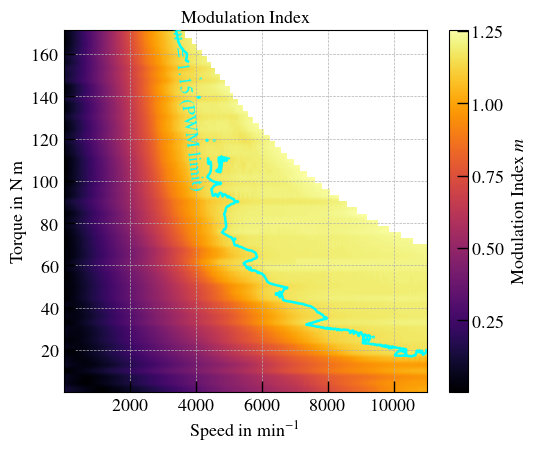

In [12]:
"""
Plot modulation index heatmap over speed/torque operating range.

Visualization:
- Color: Modulation index 
- X-axis: Speed (mechanical RPM)
- Y-axis: Torque (N·m)
- Contour: PWM limit at m = 1.1547 (theoretical linear modulaion limit)
- Masked: Infeasible regions (voltage/current constraints violated)

Interpretation:
- Regions with m < 1.15 are within linear PWM operating range
- Regions with m ≥ 1.15 require overmodulation (nonlinear PWM distortion)
"""

# ========== Data Preparation ==========
m_plot = m.T                       # Transpose: (n_trqs, n_speeds)
mask_plot = mask.T                 # Transpose to match m_plot

# Apply mask: NaN for infeasible regions (greyed out)
m_masked = np.where(mask_plot, m_plot, np.nan)

# ========== Create Figure ==========
plt.figure(figsize=(5.5, 4.6))

# ========== Heatmap ==========
im = plt.imshow(
    m_masked,
    extent=[speed_scaled_mech[0], speed_scaled_mech[-1],
            sorted_trq[0], sorted_trq[-1]],
    origin="lower",
    aspect="auto",
    cmap="inferno"
)

# ========== Colorbar ==========
cbar = plt.colorbar(im, label=r"Modulation Index $m$")
cbar.locator = MaxNLocator(nbins=6)
cbar.update_ticks()

# ========== Grid Setup for Contours ==========
Sgrid, Tgrid = np.meshgrid(speed_scaled_mech, sorted_trq)

# ========== PWM Limit Contour ==========
levels = [1.1547]
labels = [r"$m=1.15$ (PWM limit)"]
colors = ["cyan", "lime", "white"]

for lev, col, lab in zip(levels, colors, labels):
    cs = plt.contour(
        Sgrid, Tgrid, m_masked,
        levels=[lev],
        colors=[col],
        linewidths=1.8
    )
    plt.clabel(cs, fmt={lev: lab}, inline=True, fontsize=13)

# ========== Labels and Formatting ==========
plt.xlabel(r"Speed in $\si{\minute}^{-1}$")
plt.ylabel(r"Torque in \si{\newton\meter}")
plt.title(r"Modulation Index")
plt.tight_layout()

plt.show()

#### Compute Steady-State Error Statistics

Calculate mean absolute error (MAE) for selected features binned by torque and speed.

In [13]:
"""
Compute steady-state error statistics across the operating grid.

This computes mean absolute error (MAE) for each operating point:
- Compares simulated observations to analytical reference
- Focuses on steady-state region (after settling transient)
- Organizes errors by torque and speed bins for visualization

Returns: Dictionary of error statistics per feature
"""

# Calculate mean absolute error (MAE) for features
error_means = compute_steady_state_error(
    sim_trimmed,
    ref_trimmed,
    features_idx,
    sorted_trq_idx,
    sorted_trq,
    Re_scale,
)

C:\Users\Ali Abdelwanis\Documents\Research\Workspaces\Github\latest\meta-DPC-DTC-\policy\evaluation.py:193: RuntimeWarning: Mean of empty slice
  error_mean = np.nanmean(error_masked, axis=2)


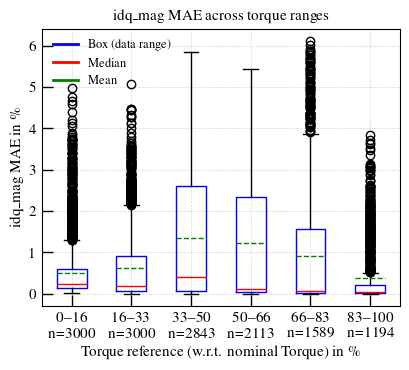

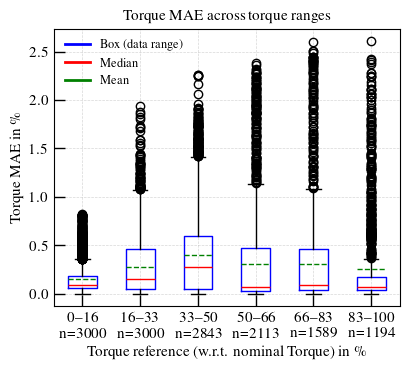

In [14]:
"""
Plot boxplot of steady-state error statistics binned by torque reference.

Visualization shows distribution of MAE across:
- Multiple torque bins (6 bins)
- Multiple features (current magnitude, torque)

This reveals how tracking error varies with operating point.
"""

# Plot error statistics binned by torque
boxplot_error_by_bins(
    error_mean=error_means,
    features=feature,
    sorted_x=trq[sorted_trq_idx],              # Sorted torque values
    sorted_x_idx=sorted_trq_idx,
    bin_values=[6, 6],                         # Number of bins
    features_indx=features_idx,
    bin_type="Torque",                         # Bin type (could be 'Speed')
)

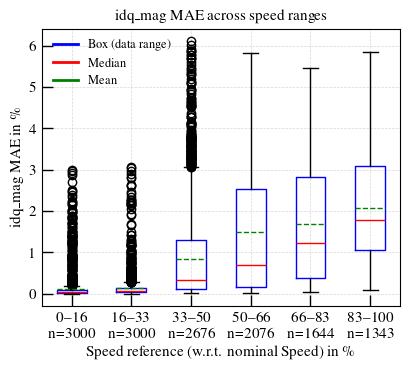

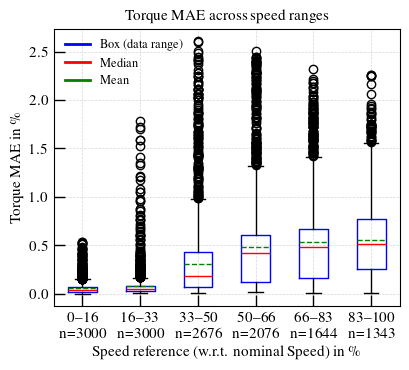

In [15]:
"""
Plot boxplot of steady-state error statistics binned by speed reference.

Visualization shows distribution of MAE across:
- Multiple speed bins (6 bins)
- Multiple features (current magnitude, torque)

This reveals dependency of control performance on motor speed.
"""

# Plot error statistics binned by speed
boxplot_error_by_bins(
    error_mean=error_means,
    features=feature,
    sorted_x=speed,                            # Speed values (not sorted)
    sorted_x_idx=sorted_trq_idx,
    bin_values=[6, 6],                         # Number of bins
    features_indx=features_idx,
    bin_type="Speed",                          # Bin by speed
)

## 6. Transient Analysis

### Evaluate Policy Over Fine Grid for Detailed Transient Comparison (smaller scale)

#### Generate Fine Grid for OCP Comparison

This grid is chosen to be computationally manageable for solving OCP benchmark
while still providing adequate spatial resolution for visualization.

**Grid Configuration:**
- Speeds: 24 points (manageable for OCP computation)
- Torques: 51 points (square-ish grid for visualization)
- Step length: 30 timesteps (short trajectory, focus on transient)

In [16]:
"""
Evaluate policy over coarser speed/torque grid for OCP comparison.

Grid Configuration:
- Speeds: 24 linearly-spaced points
- Torques: 51 linearly-spaced points (shuffled for sampling)
- Step length: 30 timesteps (faster than steady-state evaluation)
- Total points: 24 × 51 = 1,224 operating points
"""

# ========== Grid Configuration ==========
n_speeds = 24                      # Number of speed evaluation points
n_trqs = 51                        # Number of torque evaluation points
step_len = 30                      # Rollout length (timesteps)

# ========== Generate Grid Points ==========
speed = jnp.linspace(1e-4, 1, n_speeds)     # Normalized electrical speed
trq = jnp.linspace(1e-4, 1, n_trqs)         # Normalized torque
trq = jax.random.permutation(jax.random.PRNGKey(0), trq)  # Shuffle

# ========== Accumulation Lists ==========
obs_list = []
obs_des_list = []
obs_ref_list = []
acts_list = []

# ========== Nested Loop: Evaluate All Combinations ==========
for i in speed:
    """Inner loop over all torque points at fixed speed"""
    obs, _, acts, obs_des, obs_ref_ana, _ = steps_eval_manual(
        motor_env,
        reset,
        generate_feasible,
        p2,
        featurize,
        jax.random.PRNGKey(2),
        trq,                       # All torques at this speed
        plot=False,
        omega_el_coeff=i,          # Fixed speed for this iteration
        step_lens=[step_len, step_len]
    )

    # Extract analytical and simulated states
    ref_state = motor_env.vmap_generate_state_from_observation(
        obs_ref_ana, motor_env.env_properties
    ).physical_state
    sim_state = motor_env.vmap_generate_state_from_observation(
        obs, motor_env.env_properties
    ).physical_state
    des_state = motor_env.vmap_generate_state_from_observation(
        obs_des, motor_env.env_properties
    ).physical_state

    # Extract currents for validation
    id_iq_ana = jnp.concatenate(
        (ref_state.i_d.reshape(-1, 1), ref_state.i_q.reshape(-1, 1)), axis=1
    )
    id_iq_sim = jnp.concatenate(
        (sim_state.i_d.reshape(-1, 1), sim_state.i_q.reshape(-1, 1)), axis=1
    )

    # Accumulate results
    acts_list.append(acts)
    obs_list.append(obs)
    obs_ref_list.append(obs_ref_ana)
    obs_des_list.append(obs_des)

# ========== Stack Results into Arrays ==========
sim_data = jnp.stack(obs_list)
ref_data = jnp.stack(obs_ref_list)
acts_data = jnp.stack(acts_list)
des_data = jnp.stack(obs_des_list)

In [17]:
"""
Preprocess grid data for transient analysis and OCP comparison.

Configuration identical to steady-state preprocessing:
- Feature selection (current magnitude, torque)
- Grid sorting and scaling
- Feasibility mask generation
"""

# ========== Feature Configuration ==========
feature = ["idq_mag", "Torque"]
features_idx = [2, 3]              # Array indices in observation

# Scaling factors: convert from normalized [0,1] to physical units
Re_scale = [
    motor_env.env_properties.physical_constraints.i_d,
    motor_env.env_properties.physical_constraints.i_d,
    motor_env.env_properties.physical_constraints.i_d,
    motor_env.env_properties.physical_constraints.torque
]

# ========== Data Preprocessing ==========
# Remove first step (transient initialization)
sim_trimmed = sim_data[:, 1:, :]       # (n_speeds, n_trqs*step_len, num_obs)
ref_trimmed = ref_data                 # (n_speeds, n_trqs*step_len, num_obs)

# ========== Sorting and Scaling ==========
# Sort torques for monotonic x-axis
sorted_trq_idx = jnp.argsort(trq)
sorted_trq = trq[sorted_trq_idx] * motor_env.env_properties.physical_constraints.torque

# Scale speed to physical units
speed_scaled = speed * motor_env.env_properties.physical_constraints.omega_el
speed_scaled_mech = speed_scaled * 60 / (3 * 2 * jnp.pi)

# ========== Action Reshaping ==========
# Reshape control actions for grid visualization
u_d = acts_data[:, :, 0].reshape(n_speeds, n_trqs, step_len)
u_q = acts_data[:, :, 1].reshape(n_speeds, n_trqs, step_len)

# Sort by torque reference
sorted_u_d = u_d[:, sorted_trq_idx, :]
sorted_u_q = u_q[:, sorted_trq_idx, :]

## 7. OCP Benchmark (Optional)

### Solve or Load Open-Loop Optimal Control Problem Solutions

Generate optimal control trajectories for benchmark comparison. This can be computationally intensive.

**Two Options:**
1. **Solve OCP** (Cell 1): Use CasADi/IPOPT to compute optimal trajectories (takes time)
2. **Load Cached Results** (Cell 2): Use pre-computed OCP solutions (instant)

In [ ]:
"""
Solve open-loop optimal control problem (OCP) for all grid points.

**COMPUTATIONAL INTENSIVE**: This solves 24 × 51 = 1,224 constrained optimization problems.

OCP Formulation:
- Objective: Minimize tracking error + copper loss over finite horizon
- Constraints: Current magnitude, voltage hexagon (PWM limits), dynamics
- Solver: CasADi with IPOPT NLP solver
- Time horizon: Matches DPC step_len

After solving, results are reshaped into grid arrays for comparison.
"""

# This cell is optional and computationally intensive
# Uncomment to execute:
# results = generate_OCP_traj(motor_env, speed, trq, sim_data)

# After solving, extract and reshape results:
# opc_torque = np.stack([r["T_opt"][:-11] for r in results]).reshape(n_speeds, n_trqs, -1)
# opc_idq = np.stack([r["i_traj"][:-11] for r in results]).reshape(n_speeds, n_trqs, -1, 2)
# Udq_OCP = np.stack([r["U_opt"][:-11] for r in results]).reshape(n_speeds, n_trqs, -1, 2)
# u_alpha_OCP = np.stack([r["u_alpha"][:-11] for r in results]).reshape(n_speeds, n_trqs, -1)
# u_beta_OCP = np.stack([r["u_beta"][:-11] for r in results]).reshape(n_speeds, n_trqs, -1)
# speed_grid = np.array([r["omega"] for r in results]).reshape(n_speeds, n_trqs)
# torque_grid = np.array([r["T_des"] for r in results]).reshape(n_speeds, n_trqs)

print("OCP solving is optional. See next cell to load pre-computed results.")

#### Load Pre-Computed OCP Solutions (Recommended)

In [18]:
"""
Load pre-computed optimal control trajectories from saved checkpoint.

This avoids OCP solving time. Results are loaded from
.npz file containing all solutions for the 24 × 51 operating grid.

Loaded Data:
- speed_grid: Speed at each point
- torque_grid: Desired torque at each point
- trq_meas: Measured torque trajectory (OCP optimal)
- idq_meas: Measured d-q currents (OCP optimal)
- Udq_meas: D-Q voltage commands (OCP optimal)

"""

# ========== Load Parameters ==========
model_params = {
    "s": 24,                       # Number of speed points
    "t": 51,                       # Number of torque points
    "steps": 40,                  
}

# ========== Load Data ==========
data_path = generate_filename(
    project_root=PROJECT_ROOT,
    prefix="pmsm_OCP_simulation",
    extension="npz",
    params=model_params
)
data = np.load(data_path)

# ========== Extract and Reshape ==========
n_speed = len(speed)
n_torque = len(trq)

# Grids
speed_grid = data["speed_grid"]
torque_grid = data["torque_grid"]

# Trajectories 
opc_torque = data["trq_meas"][:, :, :-11]       # (n_speeds, n_trqs, 30)
opc_idq = data["idq_meas"][:, :, :-11]          # (n_speeds, n_trqs, 30, 2)
Udq_OCP = data["Udq_meas"][:, :, :-11]          # (n_speeds, n_trqs, 30, 2)

print(f"Loaded OCP solutions: {opc_torque.shape} torque trajectories")

Loaded OCP solutions: (24, 51, 30) torque trajectories


## 8. Results Visualization

### Formulate Trajectories for OCP vs DPC Comparison

In [19]:
"""
Prepare DPC and OCP trajectories for direct comparison.

Data Alignment:
- Both trajectories trimmed to match OCP length
- Scaled to physical units (N·m for torque, A for current)
- Synchronized for time-aligned comparison
"""

# ========== DPC Trajectory Reshaping and Scaling ==========
# Extract torque: (n_speeds, n_trqs, timesteps) in normalized units
dpc_torque = np.array(
    sim_data[:, :-1, 3].reshape(n_speeds, n_trqs, -1)
)[:, :, :opc_torque.shape[2]] * motor_env.env_properties.physical_constraints.torque

# Analytical reference torque
ref_dpc_trq = np.array(
    ref_data[:, :, 3].reshape(n_speeds, n_trqs, -1)
)[:, :, :opc_torque.shape[2]] * motor_env.env_properties.physical_constraints.torque

# Desired torque
des_dpc_trq = np.array(
    des_data[:, :, 3].reshape(n_speeds, n_trqs, -1)
)[:, :, :opc_torque.shape[2]] * motor_env.env_properties.physical_constraints.torque

# Extract d-q currents: (n_speeds, n_trqs, timesteps, 2) in normalized units
dpc_idq = np.array(
    sim_data[:, :-1, :2].reshape(n_speeds, n_trqs, -1, 2)
)[:, :, :opc_torque.shape[2], :] * motor_env.env_properties.physical_constraints.i_d

# Analytical reference d-q currents
ref_dpc_idq = np.array(
    ref_data[:, :, :2].reshape(n_speeds, n_trqs, -1, 2)
)[:, :, :opc_torque.shape[2], :] * motor_env.env_properties.physical_constraints.i_d

# ========== Time Axis ==========
# Create time vector for plotting (100 µs per sample)
t_steps = np.linspace(0, step_len, step_len) * 1e-4   # Convert to seconds

#### Manual Trajectory Selection

Select specific speed and torque indices for detailed visualization.

In [20]:
"""
Select specific speed and torque indices for detailed trajectory visualization.

Modify these indices to examine different operating points:
- speed_indx: 0 (low speed) to 23 (high speed)
- trq_indx: 0 (low torque) to 50 (high torque)

Example: speed_indx=23, trq_indx=50 → max speed, max torque (used in the paper)
"""

# Select operating point (speed_indx, trq_indx) for detailed analysis
speed_indx = 23                    # Speed index (0 to n_speeds-1)
trq_indx = 1                       # Torque index (0 to n_trqs-1)

#### Plot D-Q Current Trajectories

Compare d-q current components: OCP optimal vs DPC policy vs analytical reference.

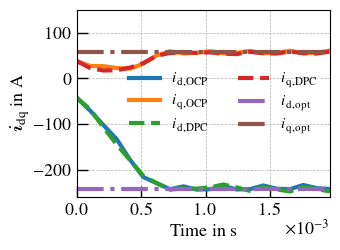

In [21]:
"""
Plot d-q current trajectories comparing OCP, DPC, and analytical reference.

Visualization:
- OCP optimal: Solid lines (theoretical best for this horizon)
- DPC policy: Dashed lines (learned control)
- Analytical ref: Dash-dot lines (equilibrium point solution)
"""

fig, ax = plt.subplots(figsize=(3.5, 2.6))

# ========== OCP Optimal Trajectory ==========
ax.plot(
    t_steps[:20], opc_idq[speed_indx, trq_indx][:20],
    label=[r"$i_\mathrm{d,OCP}$", r"$i_\mathrm{q,OCP}$"],
    linestyle="-", lw=3
)

# ========== DPC Policy Trajectory ==========
ax.plot(
    t_steps[:20], dpc_idq[speed_indx, trq_indx][:20],
    label=[r"$i_\mathrm{d,DPC}$", r"$i_\mathrm{q,DPC}$"],
    linestyle="--", lw=3
)

# ========== Analytical Reference (equilibrium) ==========
ax.plot(
    t_steps[:20], ref_dpc_idq[speed_indx, trq_indx][:20],
    label=[r"$i_\mathrm{d,opt}$", r"$i_\mathrm{q,opt}$"],
    linestyle="-.", lw=3
)

# ========== Formatting ==========
ax.set_xlabel(r"Time in \si{\second}", fontsize=13)
ax.set_ylabel(r"$\boldsymbol{i}_\mathrm{dq}$ in \si{\ampere}", fontsize=13)
ax.set_ylim([-260, 150])
ax.legend(fontsize=11, ncol=2, frameon=False)

format_time_axis_ocp_comparison(ax)
fig.tight_layout()

#### Plot Current Magnitude Trajectories

Compare current magnitude (norm) across all three controllers.

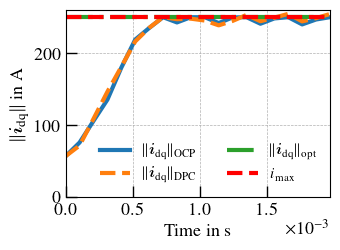

In [22]:
"""
Plot current magnitude (norm of d-q components) with constraint limit.

Visualization:
- OCP norm: Solid line (optimal utilization)
- DPC norm: Dashed line (policy output)
- Analytical ref: Dash-dot line (equilibrium magnitude)
- Max limit: Red dashed line (hardware constraint at 250A)
"""

# ========== Compute Norms ==========
opc_norm = np.linalg.norm(opc_idq[speed_indx, trq_indx], axis=1)
dpc_norm = np.linalg.norm(dpc_idq[speed_indx, trq_indx], axis=1)
ref_norm = np.linalg.norm(ref_dpc_idq[speed_indx, trq_indx], axis=1)

# ========== Create Figure ==========
fig, ax = plt.subplots(figsize=(3.5, 2.6))

# ========== OCP Norm Trajectory ==========
ax.plot(
    t_steps[:20], opc_norm[:20],
    label=r"$\|\boldsymbol{i}_\mathrm{dq}\|_\mathrm{OCP}$",
    lw=3
)

# ========== DPC Norm Trajectory ==========
ax.plot(
    t_steps[:20], dpc_norm[:20],
    label=r"$\|\boldsymbol{i}_\mathrm{dq}\|_\mathrm{DPC}$",
    linestyle="--", lw=3
)

# ========== Analytical Reference Norm ==========
ax.plot(
    t_steps[:20], ref_norm[:20],
    label=r"$\|\boldsymbol{i}_\mathrm{dq}\|_\mathrm{opt}$",
    linestyle="-.", lw=3
)

# ========== Current Limit ==========
ax.plot(
    t_steps[:20], np.ones(20) * 250,
    label=r"$i_\mathrm{max}$",
    linestyle="--", color="r", lw=3
)

# ========== Formatting ==========
ax.set_xlabel(r"Time in \si{\second}", fontsize=13)
ax.set_ylabel(r"$\|\boldsymbol{i}_\mathrm{dq}\|$ in \si{\ampere}", fontsize=13)
ax.set_ylim([0, 260])
ax.legend(fontsize=11, ncol=2, frameon=False)

format_time_axis_ocp_comparison(ax)
fig.tight_layout()

#### Plot Torque Trajectories

Compare torque tracking: OCP, DPC, and reference with ±10% tolerance band.

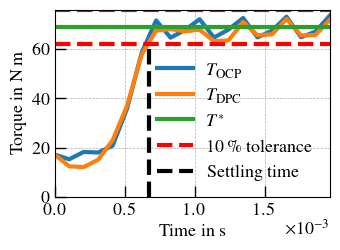

In [23]:
"""
Plot torque tracking comparison with tolerance band and settling time indicator.
"""

# ========== Create Figure ==========
fig, ax = plt.subplots(figsize=(3.5, 2.6))

# ========== OCP Torque ==========
ax.plot(
    t_steps[:20], opc_torque[speed_indx, trq_indx][:20],
    label=r"$T_\mathrm{OCP}$"
)

# ========== DPC Torque ==========
ax.plot(
    t_steps[:20], dpc_torque[speed_indx, trq_indx][:20],
    label=r"$T_\mathrm{DPC}$"
)

# ========== Reference Torque ==========
ax.plot(
    t_steps[:20], ref_dpc_trq[speed_indx, trq_indx][:20],
    label=r"$T^*$"
)

# ========== Desired Torque ==========
#ax.plot(
#    t_steps[:20], des_dpc_trq[speed_indx, trq_indx][:20],
#    label=r"$T^*$"
#)

# ========== Tolerance Band (±10%) ==========
tol = 0.1 * ref_dpc_trq[speed_indx, trq_indx][:20]
ax.plot(
    t_steps[:20], ref_dpc_trq[speed_indx, trq_indx][:20] + tol,
    linestyle="--", color="r"
)
ax.plot(
    t_steps[:20], ref_dpc_trq[speed_indx, trq_indx][:20] - tol,
    linestyle="--", color="r",
    label=r"\SI{10}{\percent} tolerance"
)

# ========== Settling Time Marker ==========
ax.vlines(
    x=t_steps[6] + 5e-5,
    ymin=0,
    ymax=(ref_dpc_trq[speed_indx, trq_indx][:20] - tol)[0],
    linestyles="--",
    color="black",
    label="Settling time"
)

# ========== Formatting ==========
ax.set_xlabel(r"Time in \si{\second}")
ax.set_ylabel(r"Torque in \si{\newton\meter}")
ax.legend(frameon=False)

format_time_axis_ocp_comparison(ax)
fig.tight_layout()

calculate settling time for grid

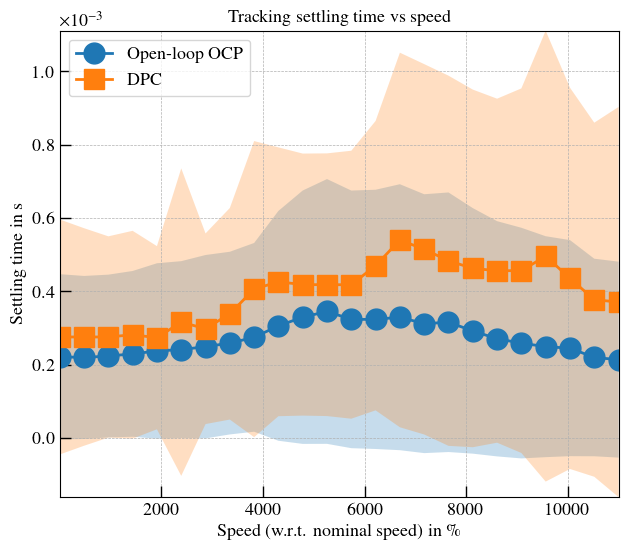

In [24]:
"""
Calculate settling time statistics for grid of operating points.    
Computes mean and standard deviation of settling times for both 
OCP and DPC controllers across a grid of speed/torque operating points.
"""
T_OCP_avg, T_DPC_avg, T_OCP_std, T_DPC_std = calculate_settling_for_grid(opc_torque, dpc_torque, ref_dpc_trq)

plt.figure(figsize=(6.5, 5.6))

plt.plot(
    speed_scaled_mech,
    T_OCP_avg,
    'o-',
    linewidth=2,
    label=r'Open-loop OCP'
)

plt.plot(
    speed_scaled_mech,
    T_DPC_avg,
    's-',
    linewidth=2,
    label=r'DPC'
)

plt.fill_between(
    speed_scaled_mech,
    T_OCP_avg - T_OCP_std,
    T_OCP_avg + T_OCP_std,
    alpha=0.25
)

plt.fill_between(
    speed_scaled_mech,
    T_DPC_avg - T_DPC_std,
    T_DPC_avg + T_DPC_std,
    alpha=0.25
)

plt.xlabel(r"Speed (w.r.t. nominal speed) in \si{\percent}")
plt.ylabel(r"Settling time in \si{\second}")
plt.title(r"Tracking settling time vs speed")
plt.grid(True)
plt.legend()
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-3, -3))  
formatter.set_useOffset(False)      
plt.gca().yaxis.set_major_formatter(formatter) 
plt.tight_layout()
plt.margins(x=0, y=0)

plt.show()
